# Multi Label Image Classification

> Motivation : https://www.clarifai.com/demo <br />
> Data : http://lamda.nju.edu.cn/data_MIMLimage.ashx?AspxAutoDetectCookieSupport=1 <br />
> Paper : http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/nips06.pdf

In [1]:
%matplotlib inline
    
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
f = h5py.File("./data/08/dataset.h5")
x = f['x'].value
y = f['y'].value
f.close()
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)

In [3]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [4]:
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),padding='same',input_shape=(3 , 100, 100)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 100, 100)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 100, 100)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 98, 98)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 98, 98)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 49, 49)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 49, 49)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 49, 49)        18496     
__________

In [6]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.load_weights("./data/08/weights.hdf5")

In [7]:
out = model.predict_proba(x_test)
out = np.array(out)

In [8]:
out

array([[  5.25076203e-02,   3.81865650e-01,   7.11545348e-01,
          3.03906891e-02,   2.52192736e-01],
       [  5.26889190e-02,   9.62114485e-04,   2.93579310e-01,
          9.72158492e-01,   5.14680594e-02],
       [  3.49882767e-02,   3.71032394e-03,   5.97689509e-01,
          9.70311403e-01,   2.65014009e-03],
       ..., 
       [  1.75322279e-01,   4.29682294e-03,   3.18148553e-01,
          9.09448683e-01,   3.30147445e-02],
       [  4.86279791e-03,   5.00628464e-02,   5.54790735e-01,
          3.92153254e-03,   4.14285213e-01],
       [  3.66324298e-02,   5.57558119e-01,   4.78138864e-01,
          7.09356973e-03,   2.37569913e-01]], dtype=float32)

In [9]:
threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        # The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications
        acc.append( matthews_corrcoef(y_test[:,i],y_pred))
        #print (acc)
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

In [10]:
best_threshold

array([ 0.6,  0.3,  0.5,  0.3,  0.7])

In [11]:
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

In [12]:
y_pred  #predicted labels

array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       ..., 
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [13]:
y_test #actual labels

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       ..., 
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [14]:
hamming_loss(y_test,y_pred)  #the loss should be as low as possible and the range is from 0 to 1

0.1345

In [15]:
total_correctly_predicted = len([i for i in range(len(y_test)) if (y_test[i]==y_pred[i]).sum() == 5])

In [16]:
total_correctly_predicted/400. #exact accuracy for eg y_pred = [0,0,1,1,1] and y_test=[0,0,1,1,1]

0.565

In [17]:
total_correctly_predicted

226

In [18]:
from IPython.display import Image

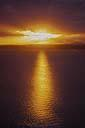

In [19]:
Image(filename='./media/08/test_image.jpg') 

In [20]:
import cv2

In [21]:
img = cv2.imread("./media/08/test_image.jpg")

In [22]:
img.shape

(128, 85, 3)

In [23]:
img = cv2.resize(img,(100,100))

In [24]:
img.shape

(100, 100, 3)

In [25]:
img = img.transpose((2,0,1))

In [26]:
img.shape

(3, 100, 100)

In [27]:
img = img.astype('float32')

In [28]:
img = img/255

In [29]:
img = np.expand_dims(img,axis=0)

In [30]:
img.shape

(1, 3, 100, 100)

In [31]:
pred = model.predict(img)

In [32]:
pred

array([[ 0.01449704,  0.00823263,  0.62959301,  0.98996872,  0.0071348 ]], dtype=float32)

In [33]:
y_pred = np.array([1 if pred[0,i]>=best_threshold[i] else 0 for i in range(pred.shape[1])])

In [34]:
y_pred

array([0, 0, 1, 1, 0])

In [35]:
classes = ['desert','mountains','sea','sunset','trees']

In [36]:
[classes[i] for i in range(5) if y_pred[i]==1 ]  #extracting actual class name

['sea', 'sunset']

In [37]:
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#import numpy as np

#img_load = mpimg.imread('test_image2.jpg')
#imgplot = plt.imshow(img_load)

In [38]:
#img_load.shape
img = cv2.imread('./media/08/test_image2.jpg')
img = cv2.resize(img,(100,100))

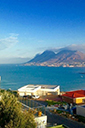

In [39]:
#imgplot = plt.imshow(img)
Image(filename='./media/08/test_image2.jpg') 

In [40]:
img = img.transpose((2,0,1))
img.shape

(3, 100, 100)

In [41]:
img = img.astype('float32')
img = img/255

In [42]:
img = np.expand_dims(img,axis=0)
img.shape

(1, 3, 100, 100)

In [43]:
pred = model.predict(img)

In [44]:
pred

array([[ 0.34226567,  0.0411748 ,  0.74226415,  0.01172697,  0.04874926]], dtype=float32)

In [45]:
y_pred = np.array([1 if pred[0,i]>=best_threshold[i] else 0 for i in range(pred.shape[1])])

In [46]:
y_pred

array([0, 0, 1, 0, 0])

In [47]:
classes = ['desert','mountains','sea','sunset','trees']

In [48]:
[classes[i] for i in range(5) if y_pred[i]==1 ]  #extracting actual class name

['sea']